# Mobility data analysis

*Author: Liubov* *Collaborators: Marc, Bastian*

Notebook inspired from Open humans project https://www.openhumans.org

Read mobility files from Open humans
https://www.openhumans.org/api/public-data/?source=direct-sharing-138


Thanks to Bastian for inspiration from their notebooks 
https://exploratory.openhumans.org/notebooks/?source=Moves%20connection



# CO2 calculation 

We first need to extract longest trips between different locations.

In [1]:

import json
from pprint import pprint


'''
Functions:
 to estimate the distribution of stop duration
 to estimate the distribution of jump length
'''

def duration_stop_distribution(daily_segments):
    """
    takes a daily segment of Moves 
    returns sorted distribution of stops duration
        Can be misleading for days w/ lots of travel etc. 
    """
    places_of_day = []
    duration_seq = [] #sequence of durations of stops
    for i in daily_segments:
        if i['type'] == 'place':
            place_location = i['place']['location']
            start_time = datetime.strptime(i['startTime'],'%Y%m%dT%H%M%S%z')
            end_time = datetime.strptime(i['endTime'],'%Y%m%dT%H%M%S%z')
            duration = end_time - start_time
            duration_seq.append([duration])
    duration_seq.sort() 
    return duration_seq 

def len_jumps_distribution(daily_segments):
    """
    takes a daily segment of Moves 
    returns the distribution of jumps lengths (calculated from lat/long of stops)
    can be misleading for days w/ lots of travel etc. 
    """
    places_of_traj = [] #returns array of all locations during the day
    for i in daily_segments: 
        if i['type'] == 'place':
            place_location = i['place']['location']
            places_of_traj.append([place_location])
    return places_of_traj


def longest_daily_location(daily_segments):
    """
    Function from Bastian (Open Humans)
    
    Bastian did analysis of most popular location data in his notebook for Open humans
    https://exploratory.openhumans.org/notebooks/?source=Moves%20connection
    
    takes a daily segment log of Moves and returns the 
    lat/long for the location where most time was spent. 
    Can be misleading for days w/ lots of travel etc. 
    But the most quick/dirty solution for now.
    """
    places_of_day = []
    for i in daily_segments:
        if i['type'] == 'place':
            place_location = i['place']['location']
            start_time = datetime.strptime(i['startTime'],'%Y%m%dT%H%M%S%z')
            end_time = datetime.strptime(i['endTime'],'%Y%m%dT%H%M%S%z')
            duration = end_time - start_time
            places_of_day.append([place_location,duration])
    places_of_day.sort(key=lambda tup: tup[-1],reverse=True)
    return places_of_day[0][0]

# Data extraction and preprocessing 

In [2]:
# main function analyzing moves_data    
DATARANGE_START = "2016-06-01"
DATARANGE_END = "2018-05-08"

import os
import json
import requests
from datetime import datetime
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns


# sets the axis label sizes for seaborn
rc={'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 14.0, 
    'axes.titlesize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
sns.set(rc=rc)

with open('moves-storyline-data.json') as f:
    moves_data = json.load(f)
    
with open('moves-storyline-data98933.json') as f: #uploading different datafiles
    moves_data2 = json.load(f)

with open('moves-storyline-data98972.json') as f:
    moves_data3 = json.load(f)   
    
#for printing this huge file of trajectories:    
#pprint(data)
    

moves_processed_data = defaultdict(list) #empty dict for processed dataframe

'''
function to create new dataframe from the json trajectory file
code adapted from openhumans notebook
'''

def dataframe_from_json(moves_data):
    for datapoint in moves_data:
        # we need to have observed segments for that day. If moves wasn't running we ignore the day
        if datapoint['segments'] != None:
            # did we stay in a place that day and did we walk that day?
            has_places = False
            walked = False
            for i in datapoint['segments']:
                if i['type'] == 'place':
                        # yes, we were in one place w/o moving around too much, we can keep this day
                        has_places = True
                        
            # is this day in our date range of interest and has data?
            if datapoint['summary'] != None and has_places and datetime.strptime(datapoint['date'],"%Y%m%d") > datetime.strptime(DATARANGE_START,"%Y-%m-%d"):
                moves_processed_data['date'].append(datapoint['date'])
                for activity in datapoint['summary']:
                    if activity['activity'] == 'walking':
                        moves_processed_data['steps'].append(activity['steps'])
                        moves_processed_data['distance'].append(activity['distance'])
                        walked = True
                        
                # in case of not walking, step count is zero
                if not walked:
                    moves_processed_data['steps'].append(0)
                    moves_processed_data['distance'].append(0)  
                    
                # distribution of stops lengths
                stops_distrib = duration_stop_distribution(datapoint['segments'])
                moves_processed_data['duration'].append(stops_distrib)
                location = longest_daily_location(datapoint['segments'])
                moves_processed_data['lat'].append(location['lat'])
                moves_processed_data['lon'].append(location['lon'])    
    
    
    
    #Now that we have all of the data we can convert it into a single pandas dataframe for easier processing and visualization
    
    moves_dataframe = pd.DataFrame(data={
        'date': moves_processed_data['date'],
        'steps': moves_processed_data['steps'],
        'distance': moves_processed_data['distance'],
        'latitude': moves_processed_data['lat'],
        'longitude': moves_processed_data['lon']
    })   
    
    return moves_dataframe

# function to get data from json data
df1 = dataframe_from_json(moves_data)
df2 = dataframe_from_json(moves_data2)
df3 = dataframe_from_json(moves_data3)

#print shape of data
array_distance = df1.distance.values 
type(array_distance)


print('Now data looks like...')
df1.head(10)

Now data looks like...


,date,steps,distance,latitude,longitude
0,20160602,8732,6994.0,32.716960,-117.13974
1,20160603,5773,4391.0,33.998820,-118.43657
2,20160604,3083,2232.0,33.998820,-118.43657
3,20160605,6676,4216.0,33.998820,-118.43657
4,20160606,4936,3136.0,33.998820,-118.43657
5,20160607,7130,5342.0,33.998820,-118.43657
6,20160608,4880,3641.0,33.998820,-118.43657
7,20160609,3892,2730.0,33.998820,-118.43657
8,20160611,5363,3946.0,32.804227,-117.25982
9,20160612,3458,2406.0,32.804227,-117.25982


## Longest location jumps extraction

We calculate distribution of distances and take those which are the longest. 



In [8]:
import osmnx as ox
import networkx as nx
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

#lat1 = radians(52.2296756)
#lon1 = radians(21.0122287)
#lat2 = radians(52.406374)
#lon2 = radians(16.9251681)

def dist_km(lat1,lat2,lon1,lon2):
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance 

# get the nearest network node to each point

#orig_node = ox.get_nearest_node(G, (lat1, lon1))#(37.828903, -122.245846))
#dest_node = ox.get_nearest_node(G, (lat2, lon2))#(37.812303, -122.215006))

# how long is our route in meters to drive
#nx.shortest_path_length(G, orig_node, dest_node, weight='length')


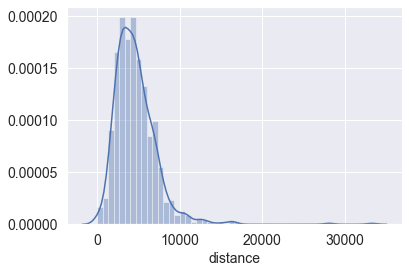

In [14]:
sns.distplot(df1['distance'])

size  712
Index(['date', 'steps', 'distance', 'latitude', 'longitude'], dtype='object')


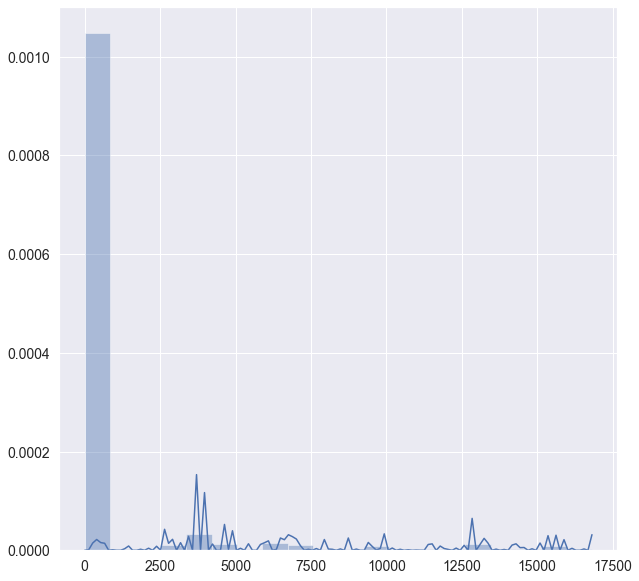

In [13]:
# we estimate distances between lat, lon of cooridinates

import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns

size = int(df1.shape[0])
print('size ', size )

print(df1.columns)


dist_array = np.zeros(size)
for ind in range(0, size-1):
    lat1 = df1.latitude.iloc[ind] #df1['latitude'].iloc[ind]
    lat2 = df1.latitude.iloc[ind+1]
    lon1 = df1.longitude.iloc[ind]
    lon2 = df1.longitude.iloc[ind+1]
    dist_array[ind] = dist_km(lat1,lat2,lon1,lon2)

fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(dist_array, bins=20)
plt.xlabel("distance)")
plt.ylabel("frequency")
plt.show()



## CO2 calculation 
Analyse carbon footprint for longest (presumably) plane travels from the previous distribution of distances: e.g. more 5000 km.

Analysis of carbon footprint for trajectories made by plane. We will use the following sources for this calculation.

The carbon footprint calculator https://www.carbonfootprint.com/calculator.aspx